# Introduction

This notebook will demonstrate the BranchKey implementation of federated learning on a disitributed machine learning problem focusing on Breast Cancer detection.

## Problem:
Multiple medical centres have compiled patient records collected from breast cancer screening at their location. These records contain sensitive information about each patient, so each medical centre has performed analysis on the raw images giving us 10 features on each growth identified in the images such as the radius, texture, perimeter etc in each sample. This way the raw image is no longer needed, however, this data is still medical data relating to an individual and as such can not leave the medical centre. How can this data be used safely to learn from without exposing the data to risk of exposure?

## Proposed solution:
Each medical centre will deploy their own model to learn from the local data they have. Using a machine learning federation each model will communicate with each other and share the high-level information being learned at each medcial centre. Together the federation will solve the problem, without sharing any of the medical data.


# Table of Contents
- [Setup](#Setup)
- [Dataset](#Dataset)
    - [Attribute Information](#Attribute-Information:)
    - [Preprocessing](#Data-Preprocessing)
    - [Selecting input Features](#Selecting-input-features)
    - [Normalisation](#Normalisation)
- [Machine Learning](#Machine-Learning)
    - [Model Definition](#Model-Definition)
    - [Optimizer and Loss](#Optimizer-and-loss)
- [Using Federations](#Using-Federations)
    - [Local Baseline without Federation](#Local-Baseline-without-Federation)
    - [Using Distributed Federations](#Using-Distributed-Federations)
    - [Create BranchKey Clients and Login](#Create-BranchKey-clients-and-login)
    - [Create Models](#Create-Models)
    - [Run the Federated System with BranchKey](#Run-the-Federated-System-with-BranchKey)
- [Graph the Results](#Graph-the-Results)
- [Cleanup - IMPORTANT](#Cleanup)

# Setup

Import the packages needed for this notebook to run

In [1]:
# Foreign imports
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
from branchkey.client import Client

# Native imports
import csv
import json
from queue import Queue
import warnings
import logging
from os.path import exists
import os
import shutil

# Pytorch
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

logging.basicConfig(format='%(asctime)s --- %(levelname)s:%(message)s')
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Dataset

Citation: `Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.`


In [2]:
datasets = []
for i in range(5):
    data = []
    with open(f'dataset/split-{i}.csv', newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in csv_reader:
            data.append(row)
    datasets.append(np.float32(data[3:]))
col_names = data[0]
min_limit = np.float32(data[1])
max_limit = np.float32(data[2])
del data

In [3]:
print(len(min_limit))
print(len(datasets[0][0]))

32
32


### Load test dataset
Our test dataset is fixed for all models, this is to give consistent test results.

In [4]:
test_data = []
with open(f'dataset/test.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in csv_reader:
        test_data.append(row)
test_col_names = test_data[0]
test_min_limit = test_data[1][2:]
test_max_limit = test_data[2][2:]
test_data = np.float32(test_data[3:])

### Attribute Information:
1) ID number
2) Diagnosis (M = malignant, B = benign)


Ten real-valued features are computed for each cell nucleus:

1. radius (mean of distances from center to points on the perimeter)
2. texture (standard deviation of gray-scale values)
3. perimeter
4. area
5. smoothness (local variation in radius lengths)
6. compactness (perimeter^2 / area - 1.0)
7. concavity (severity of concave portions of the contour)
8. concave points (number of concave portions of the contour)
9. symmetry
10. fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.


In [5]:
print(f"Column Names:\n{col_names}\n")
print(f"Sample entry:\n{datasets[0][0]}\n")
print(f"Length of a dataset:\n{len(datasets[0][0])}")

Column Names:
['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

Sample entry:
[8.42302e+05 1.00000e+00 1.79900e+01 1.03800e+01 1.22800e+02 1.00100e+03
 1.18400e-01 2.77600e-01 3.00100e-01 1.47100e-01 2.41900e-01 7.87100e-02
 1.09500e+00 9.05300e-01 8.58900e+00 1.53400e+02 6.39900e-03 4.90400e-02
 5.37300e-02 1.58700e-02 3.00300e-02 6.19300e-03 2.53800e+01 1.73300e+01
 1.84600e+02 2.01900e+03 1.62200e-01 6.65600e-01 7.11900e-01 2.65400e-01
 4.60100e-01 1.18900e-01]

Length of a da

In [6]:
# Remove first 2 columns from train set i.e. ID and Diagnosis
col_names = col_names[2:]
min_limit = min_limit[2:]
max_limit = max_limit[2:]

## Data Preprocessing

Let's find the important variables in our dataset and build a classifer based on their correlational siginificance to the outcome

In [7]:
x = datasets[0][:, 2:]
y = datasets[0][:, 1]
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=int)

In [8]:
corr_mean = {}
corr_se= {}
corr_worst = {}
for idx, col in enumerate(col_names[2:12]):
    corr_mean[col] = pearsonr(x[:, idx], y)
    
for idx, col in enumerate(col_names[12:22]):
    corr_se[col] = pearsonr(x[:, idx+10], y)
    
for idx, col in enumerate(col_names[22:]):
    corr_worst[col] = pearsonr(x[:, idx+20], y)

In [9]:
# Perform some basic p value analysis. Find and order the most relevant features to build our model 
corr = {key: val for key, val in sorted(corr_mean.items(), key = lambda ele: ele[1][1])}
for c in corr:
    if corr[c][1] < 0.005:
        print("HIGHLY:\t\t {} :: {}".format(c, corr[c]))
    elif corr[c][1] < 0.05:
        print("STRONGLY:\t\t {} :: {}".format(c, corr[c]))
    elif corr[c][1] < 0.5:
        print("WEAKLY:\t\t {} :: {}".format(c, corr[c]))
    else:
        print("INSIGNIFICANT:\t {} :: {}".format(c, corr[c]))

HIGHLY:		 fractal_dimension_mean :: (0.6968688164146779, 1.697717722193376e-14)
HIGHLY:		 smoothness_mean :: (0.6655374546832926, 6.161335599708992e-13)
HIGHLY:		 perimeter_mean :: (0.648846632406865, 3.521084650337596e-12)
HIGHLY:		 compactness_mean :: (0.6166439200910341, 7.623781055256587e-11)
HIGHLY:		 symmetry_mean :: (0.5976619706085571, 3.9878789062374023e-10)
HIGHLY:		 concave points_mean :: (0.5385115650413694, 3.6725622723038454e-08)
HIGHLY:		 area_mean :: (0.4667477576892761, 3.1083653317962473e-06)
STRONGLY:		 concavity_mean :: (0.2810504775326433, 0.006962933591512423)
STRONGLY:		 radius_se :: (0.2185330755292398, 0.03742664604180766)
INSIGNIFICANT:	 texture_se :: (0.04942883647079392, 0.6417256683261412)


In [10]:
# List the names of the columns
for idx, val in enumerate(corr_mean.keys()):
    print("{} : {}".format(idx, val))

0 : perimeter_mean
1 : area_mean
2 : smoothness_mean
3 : compactness_mean
4 : concavity_mean
5 : concave points_mean
6 : symmetry_mean
7 : fractal_dimension_mean
8 : radius_se
9 : texture_se


## Selecting input features

W're going to choose the top 4 features identified based on their [pearson correlation coeffcient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) ( the *p-vlaue* ) as a measure of their significance in relation to the outcome.

So, we choose (these can change depending on your dataset, so do some tweaking to find the best):
- Radius Mean
- Perimeter Mean
- Area Mean
- Concave Points Mean

### Normalisation

Rescale the inputs from their [0-200] ranges into a normalised [0-1] range using [min-max normalisation](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)):

$$
x' = \frac{x-x_{min}}{x_{max}-x_{min}}
$$

Note: The min and max of each feature have been precalculated for consistency in this example. They can be found in the *min\_limit*, and *max\_limit* arrays.

In [11]:
cleaned_datasets = []
for idx, dataset in enumerate(datasets):
    x = dataset[:, 2:]
    y = dataset[:, 1]
    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=int)
    
    x_test = np.array(test_data[:, 2:], dtype=np.float32)
    y_test = test_data[:, 1]
    
    for x_i in x:
        for idx, x_j in enumerate(x_i):
            x_i[idx] =  (x_j-min_limit[idx])/(max_limit[idx]-min_limit[idx])
            
    for x_i in x_test:
        for idx, x_j in enumerate(x_i):
            x_i[idx] =  (x_j-min_limit[idx])/(max_limit[idx]-min_limit[idx])
    
    
    features = np.array([np.array(x[:, 0]), np.array(x[:, 2]), np.array(x[:, 3]), np.array(x[:, 7])])
    test_features = np.array([np.array(x_test[:, 0]), np.array(x_test[:, 2]), np.array(x_test[:, 3]), np.array(x_test[:, 7])])

    X_train = features.T
    X_test = test_features.T
    Y_train = y
    Y_test = y_test
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    X_train, Y_train = unison_shuffled_copies(X_train, Y_train)
    X_test, Y_test = unison_shuffled_copies(X_test, Y_test)    
    
    X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
    Y_train, Y_test = torch.Tensor(Y_train), torch.Tensor(Y_test)
    X_train.to(device)
    Y_train.to(device)
    X_test.to(device)
    Y_test.to(device)

    cleaned_datasets.append([X_train, Y_train, X_test, Y_test])
del x
del y

In [12]:
print(test_data[:, 2].max())
print(x_test[:, 0].max())

27.42
0.96734333


In [13]:
print(f"Total samples {len(cleaned_datasets[0][1])}")
print("Class distribution:")
print(f"\tMalignant {np.count_nonzero(cleaned_datasets[0][1]==1)}")
print(f"\tBenign {np.count_nonzero(cleaned_datasets[0][1]==0)}")

Total samples 91
Class distribution:
	Malignant 61
	Benign 30


In [14]:
print(X_train[:5, :])
print(Y_train[:5])

tensor([[0.5229, 0.5094, 0.3591, 0.3108],
        [0.2371, 0.2337, 0.1263, 0.2124],
        [0.2830, 0.2791, 0.1619, 0.0936],
        [0.3350, 0.3176, 0.1975, 0.1616],
        [0.1147, 0.1093, 0.0542, 0.0625]])
tensor([1., 0., 0., 0., 0.])


# Machine Learning

Now with our dataset prepared, features selected and normalised we can build our model and start classifying.

In [15]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Model Definition

Why build a complex model? Start small with a logistric regression and test. If this model can not deal with non-linearities in the dataset it may be time to upgrade. Let's see how it performs.

### Our Model:
Input feature vector; $$\mathbf{x} = [x_1, x_2, x_3, x_4]$$

Weight vector; $$\mathbf{w} = [w_1, w_2, w_3, w_4]$$

Bias; $$b$$

#### Linear Transform
$$f(\mathbf{x}, \mathbf{w}, b) = \mathbf{x} \cdot \mathbf{w} + b$$

#### Sigmoid
$$\sigma(x)=\frac{1}{1+exp(−x)}$$


### Model:
$$out = \sigma(f(\mathbf{x}, \mathbf{w}, b))$$

### Optimizer and loss
Adam optimiser: [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam)


Binary Cross Entropy Loss: [BCELoss()](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html?highlight=bceloss#torch.nn.BCELoss)



In [16]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)     
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [17]:
model = LogisticRegression(4,1)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.003)

In [18]:
class Model:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def evaluate(self, x, y):
        with torch.no_grad():            
            # Calculating the loss and accuracy
            total = 0
            correct = 0
            outputs = torch.squeeze(self.model(x))
            loss = self.criterion(outputs, y)
            total += y.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().cpu().numpy() == y.detach().cpu().numpy())
            accuracy = 100 * correct/total
            return accuracy, loss.item()

    def fit(self, x, y):
        self.model.train()
        outputs = self.model(x)
        labels = y

        loss = self.criterion(torch.squeeze(outputs), labels) 

        self.optimizer.zero_grad() # Setting our stored gradients equal to zero
        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

        self.optimizer.step() # Updates weights and biases with the optimizer (SGD)
        return outputs
        
    def run_model(self, epochs = 100, test_epoch = 100,
                train : dict = {'x': X_train,'y': Y_train}, 
                test : dict = {'x': X_test,'y': Y_test},
                results : dict = {'accuracy': [], 'accuracy_test': [], 'losses': [], 'losses_test': [], 'Iterations': []},
                iter = 0):

        for epoch in range(int(epochs)):
            train['x'] = train['x'].to(device)
            train['y'] = train['y'].to(device)
            test['x'] = test['x'].to(device)
            test['y'] = test['y'].to(device)
            self.fit(train['x'], train['y'])

            iter+=1
            if iter%test_epoch==0:
                accuracy, loss = self.evaluate(train['x'], train['y'])
                results['accuracy'].append(accuracy)
                results['losses'].append(loss)

                accuracy, loss = self.evaluate(test['x'], test['y'])
                results['accuracy_test'].append(accuracy)
                results['losses_test'].append(loss)

                results['Iterations'].append(iter)
        return results

In [19]:
m = Model(model, criterion, optimizer)
m.run_model()

{'accuracy': [27.47252747252747],
 'accuracy_test': [22.80701754385965],
 'losses': [0.6872022747993469],
 'losses_test': [0.6914930939674377],
 'Iterations': [100]}

# Using Federations

In [20]:
print(len(cleaned_datasets[0][3]))

114


In [21]:
splt_X_train = []
splt_Y_train = []
splt_X_test = []
splt_Y_test = []

for idx, dataset in enumerate(cleaned_datasets):
    splt_X_train.append(dataset[0])
    splt_Y_train.append(dataset[1])
    splt_X_test.append(dataset[2])
    splt_Y_test.append(dataset[3])
print(splt_X_train[0].shape)
print(splt_Y_train[0].shape)
print(splt_X_test[0].shape)
print(splt_Y_test[0].shape)

for idx in range(len(splt_X_train)):
    splt_X_train[idx].to(device)
    splt_Y_train[idx].to(device)

for idx in range(len(splt_X_test)):
    splt_X_test[idx].to(device)
    splt_Y_test[idx].to(device)

torch.Size([91, 4])
torch.Size([91])
torch.Size([114, 4])
torch.Size([114])


## Local Baseline without Federation

In [22]:
models = []
for ds_idx in range(len(splt_X_train)):
    m = LogisticRegression(4,1)
    optim = torch.optim.Adam(m.parameters(), lr=.003)
    loss = torch.nn.BCELoss()
    m.to(device)
    models.append(Model(m, loss, optim))

In [23]:
client_results : dict = {}
for ds_idx, m in enumerate(models):
    client_results[ds_idx] = []

logger.info("Training clients")
for i in trange(200):
    for ds_idx, m in enumerate(models):
        ep = 10
        client_results[ds_idx].append({'accuracy': [], 'accuracy_test': [], 'losses': [], 'losses_test': [], 'Iterations': []})
        m.run_model(epochs=ep, test_epoch=ep, iter=(ep*i)-1, 
                    test={'x': X_test.to(device), 'y': Y_test.to(device)},
                    train={'x': splt_X_train[ds_idx].to(device), 'y': splt_Y_train[ds_idx].to(device)},
                    results=client_results[ds_idx][-1])
print("done")

2022-07-07 16:33:29,589 --- INFO:Training clients


  0%|          | 0/200 [00:00<?, ?it/s]

done


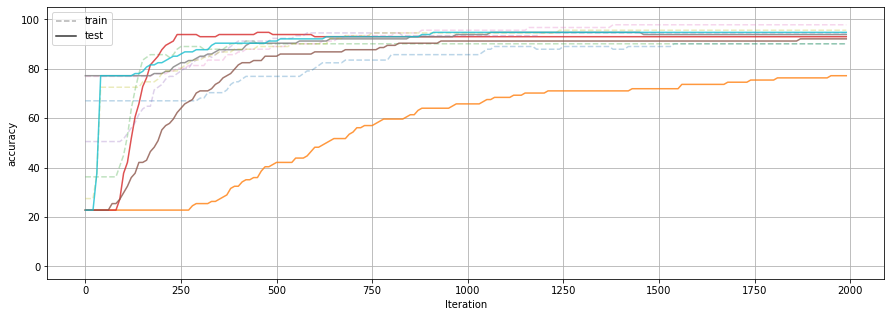

In [24]:
plt.figure(figsize=(15,5))
plt.grid()
plt.ylim(-5, 105)
plt.xlabel("Iteration")
plt.ylabel("accuracy")

baseline_final_acc = []
baseline_final_test_acc = []
for client in client_results:
    baseline_acc = []
    baseline_test_acc = []
    iter = []
    for res in client_results[client]:
        baseline_acc.append(res['accuracy'])
        baseline_test_acc.append(res['accuracy_test'])
        iter.append(res['Iterations'])
    baseline_acc = np.array(baseline_acc)
    baseline_test_acc = np.array(baseline_test_acc)
    plt.plot(iter, baseline_acc, alpha=0.3, linestyle='--')
    plt.plot(iter, baseline_test_acc, alpha=0.8)
    baseline_final_acc.append(baseline_acc)
    baseline_final_test_acc.append(baseline_test_acc)
baseline_final_acc = np.array(baseline_final_acc)
baseline_final_test_acc = np.array(baseline_final_test_acc)

plt.plot(0, 0, alpha=0.3, color='black', linestyle='--', label='train')
plt.plot(0, 0, alpha=0.8, color='black', label='test')
plt.legend()

if not os.path.isdir('./images'):
    os.mkdir('./images')
plt.savefig('./images/non-fed.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
mean = 0
for a in baseline_final_test_acc:
    mean+=a[-1]
mean = mean / len(baseline_final_test_acc)
print(mean)

[90.1754386]


In [26]:
print(client_results.keys())
res = client_results[0][0]
print(f"Iteration: {res['Iterations']}. \nTest - Loss: {res['losses_test']}. Accuracy: {res['accuracy_test']}")
print(f"Train -  Loss: {res['losses']}. Accuracy: {res['accuracy']}\n")

dict_keys([0, 1, 2, 3, 4])
Iteration: [0]. 
Test - Loss: [0.8388291597366333]. Accuracy: [22.80701754385965]
Train -  Loss: [0.637608528137207]. Accuracy: [67.03296703296704]



# Using Distributed Federations
## Create BranchKey clients and login

In [27]:
environment = "engine"

creds_dir = f"./{environment}"
if environment == "staging":
    api_gateway_host = f"https://api.staging.branchkey.com"
else:
    api_gateway_host = f"https://api.branchkey.com"

agents = []

with open(creds_dir + '/group_details.json', 'rb') as file:
    branch_details = json.loads(file.read())
    print(branch_details.keys())
if os.path.exists(creds_dir + "/agents/.ipynb_checkpoints"):
    shutil.rmtree(creds_dir + "/agents/.ipynb_checkpoints")
dir_list = os.listdir(creds_dir + "/agents")
for f in dir_list:
    with open(creds_dir + '/agents/' + f, 'rb') as file:
        agents.append(json.loads(file.read()))
print(agents[0].keys())
print(len(agents))

dict_keys(['branch_id', 'branch_name', 'tree_id'])
dict_keys(['name', 'password'])
5


In [28]:
credentials = []
rabbitmq_configs = []
if environment == "staging":
    response_host = "response.staging.branchkey.com"
else:
    response_host = "response.branchkey.com"

for agent in agents:
    credentials.append({"leaf_name": agent['name'],
                   "leaf_password": agent['password'],
                   "tree_id": branch_details['tree_id'],
                   "branch_id": branch_details['branch_id'],
                    "response_host": response_host,
                    "port": 5672})
print(credentials[0])


{'leaf_name': 'leaf-3', 'leaf_password': 'leaf-password', 'tree_id': '3fcb0d94-2534-4dac-91b8-937410b22dc5', 'branch_id': '3b99b4ec-95ad-4101-abfb-55148d57bd78', 'response_host': 'response.branchkey.com', 'port': 5672}


In [29]:
if environment == "staging":
    warnings.filterwarnings('ignore') # Used for staging with invalid SSL certs

logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

clients = []
logger.info("Client Login:")
login_t = tqdm(total=len(credentials))
for idx, creds in enumerate(credentials):
    clients.append(Client(creds, api_gateway_host))
    logging.disable("INFO")
    if environment == "staging":
        clients[-1].disable_ssl_verification() # Used for staging with invalid SSL certs
    if not clients[-1].login():
        raise Exception("Client {}: Login Failed".format(idx))
    login_t.update(idx)
logging.disable(logging.NOTSET)
warnings.resetwarnings()

2022-07-07 16:33:35,969 --- INFO:Client Login:


  0%|          | 0/5 [00:00<?, ?it/s]

## Create Distributed Models

In [30]:
models = []
for ds_idx in range(len(splt_X_train)):
    m = LogisticRegression(4,1)
    optim = torch.optim.Adam(m.parameters(), lr=0.003)
    loss = torch.nn.BCELoss()
    m.to(device)
    models.append(Model(m, loss, optim))
for client in clients:
    while not client.queue.empty():
        client.queue.get()

## Run the Federated System with BranchKey

In [31]:
client_results : dict = {}
for ds_idx, m in enumerate(models):
    client_results[ds_idx] = []
if not os.path.isdir('./aggregated_output'):
    os.mkdir('./aggregated_output')
    
logger.info("Running clients")
for i in trange(40):
    for ds_idx, m in enumerate(models):
        ep = 5
        client_results[ds_idx].append({'accuracy': [], 'accuracy_test': [], 'losses': [], 'losses_test': [], 'Iterations': []})
        m.run_model(epochs=ep, test_epoch=ep, iter=(ep*i)-1,
                  test={'x': X_test.to(device), 'y': Y_test.to(device)},
                  train={'x': splt_X_train[ds_idx].to(device), 'y': splt_Y_train[ds_idx].to(device)},
                  results=client_results[ds_idx][-1])
        ####################
        # Aggregation Step #
        ####################
        params = []
        for name, param in m.model.named_parameters():
            params.append([name, param.cpu()])
        m.model.to(device)
        update = clients[ds_idx].convert_pytorch_numpy(params)


        with open("./test.npy", "wb") as f:
            np.save(f, update)
        for attempt in range(3):
            try:
                logger.debug("Parameters uploaded: {}".format(clients[ds_idx].file_upload("test.npy")))
                break
            except Exception as e:
                logger.debug("Upload Error {}".format(e))
                logger.warning("Retrying Upload: {}/3".format(attempt+1))
                if attempt == 2:
                    logger.error("Fatal Upload Error {}".format(e))
        
        if clients[ds_idx].run_status == 'start':
            continue
        elif clients[ds_idx].run_status == 'stop':
            break
        
        if not clients[ds_idx].queue.empty():            
            agg_id = clients[ds_idx].queue.get(block=False)
            try:
                if not exists("./aggregated_output/" + agg_id):
                    logger.debug("File {} Downloaded successfully: {}".format(agg_id, clients[ds_idx].file_download(agg_id)))
                else:
                    logger.debug("File {} exists".format(agg_id))
            except Exception as e:
                logger.error("Error with file download: {}".format(e))
                continue

            new_params = np.load("./aggregated_output/" + agg_id, allow_pickle=True)
            for param, new_param in zip(m.model.named_parameters(), new_params):
                param[1].data = torch.from_numpy(new_param)
                m.model.to(device)
            logger.debug("Parameters loaded successfully: {}".format(agg_id))

    logger.debug("Iteration {} : complete".format(i))
logger.info("done")

2022-07-07 16:33:38,444 --- INFO:Running clients


  0%|          | 0/40 [00:00<?, ?it/s]

2022-07-07 16:33:38,474 --- INFO:[Consumer] Starting rabbitmq consumer
2022-07-07 16:33:39,807 --- ERROR:Error with file download: File Download failed for leaf-3 for file 31255a51-eb75-417c-8707-3b827d59ea7e: api_gateway:internal server error
2022-07-07 16:33:40,418 --- WARNING:Retrying Upload: 1/3
2022-07-07 16:34:19,095 --- INFO:done


## Graph the Results

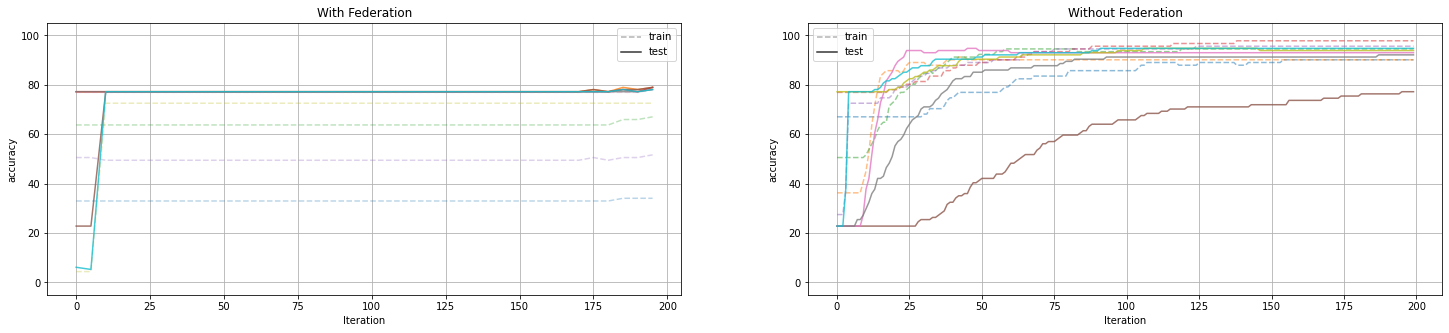

In [32]:
plt.figure(figsize=(25,5))
plt.subplot(121)
plt.title("With Federation")
plt.grid()
plt.ylim(-5, 105)
plt.xlabel("Iteration")
plt.ylabel("accuracy")

final_acc = []
final_test_acc = []
for client in client_results:
    acc = []
    test_acc = []
    iter = []
    for res in client_results[client]:
        acc.append(res['accuracy'])
        test_acc.append(res['accuracy_test'])
        iter.append(res['Iterations'])
    acc = np.array(acc)
    test_acc = np.array(test_acc)
    plt.plot(iter, acc, alpha=0.3, linestyle='--')
    plt.plot(iter, test_acc, alpha=0.8)
    final_acc.append(acc)
    final_test_acc.append(test_acc)
final_acc = np.array(final_acc)    
final_test_acc = np.array(final_test_acc)    
plt.plot(0, 0, alpha=0.3, color='black', linestyle='--', label='train')
plt.plot(0, 0, alpha=0.8, color='black', label='test')
plt.legend()

plt.subplot(122)
plt.title("Without Federation")
plt.grid()
plt.ylim(-5, 105)
plt.xlabel("Iteration")
plt.ylabel("accuracy")
for train_acc in baseline_final_acc:
    plt.plot(train_acc, alpha=0.5, linestyle='--')
for test_acc in baseline_final_test_acc:
    plt.plot(test_acc, alpha=0.8)
    
plt.plot(0, 0, alpha=0.3, color='black', linestyle='--', label='train')
plt.plot(0, 0, alpha=0.8, color='black', label='test')
plt.legend()

if not os.path.isdir('./images'):
    os.mkdir('./images')
plt.savefig('./images/fed.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
mean = 0
for a in final_test_acc:
    mean+=a[-1]
mean = mean / len(final_test_acc)
print(mean)

[78.59649123]


# Cleanup

In [34]:
for c in clients:
    try:
        print(f"Leaf {c.leaf_id}:: Logged out : {c.logout()}")
    except Exception as e:
        print(f"Erorr with logging out {c.leaf_id}: {e}")
if os.path.isfile('./test.npy'):
    os.remove('./test.npy')
shutil.rmtree("aggregated_output")
os.makedirs("aggregated_output")
logger.info(f"aggregated_output : directory cleared")

Leaf 54a72b02-90a9-49ef-bef9-9926e083133b:: Logged out : True
Leaf ea4e67d3-2b33-4c6d-a35a-f7f1e72131a5:: Logged out : True
Leaf 51472c18-3d6c-4944-9e43-b9358dfd8982:: Logged out : True
Leaf 2ff48280-aae8-49c5-86c4-b2819d1fedd5:: Logged out : True


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f64f84cfa00>
2022-07-07 16:34:20,609 --- INFO:aggregated_output : directory cleared


Leaf d346b1de-fe05-425e-ac67-83bd2bd43726:: Logged out : True
